# Credit Risk Prediction - TakeHome Epifi [part 2]

This Notebook contains the following sections

1. Preprocessing and data encoding
2. Model Selection
3. Finetuning the final model
4. Additional Features that could have been available

### Section 1. Preprocessing

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder,OneHotEncoder
from sklearn.metrics import confusion_matrix,precision_score,recall_score,accuracy_score
from scipy.stats import chi2_contingency

In [7]:
df_feat=pd.read_csv('cleaned_data_features.csv')

In [8]:
df_feat.columns

Index(['loan_application_id', 'Months_loan_taken_for', 'Purpose',
       'Principal_loan_amount', 'EMI_rate_in_percentage_of_disposable_income',
       'Property', 'Has_coapplicant', 'Has_guarantor', 'Other_EMI_plans',
       'Number_of_existing_loans_at_this_bank', 'Loan_history',
       'high_risk_applicant', 'Gender', 'Marital_status',
       'Number_of_dependents', 'Housing', 'Years_at_current_residence',
       'Employment_status', 'Has_been_employed_for_at_least',
       'Has_been_employed_for_at_most', 'Telephone', 'Foreign_worker',
       'Savings_account_balance',
       'Balance_in_existing_bank_account_(lower_limit_of_bucket)',
       'Balance_in_existing_bank_account_(upper_limit_of_bucket)', 'Age_bin',
       'complete_employment_current_residence', 'employment_start_age_bin',
       'monthly_emi', 'Balance_not_available',
       'Savings_balance_not_available'],
      dtype='object')

In [9]:
column_type={
'nominal':['Purpose',  'Property',
        'Other_EMI_plans','Loan_history',
        'Gender', 'Marital_status',
        'Housing', 'Employment_status',  
         'Telephone', 'Foreign_worker',
        'complete_employment_current_residence', 
        'Balance_not_available', 'Savings_balance_not_available'],

'auto_ordinal':['Age_bin','employment_start_age_bin',
              'Has_been_employed_for_at_least',
              'Has_been_employed_for_at_most',],

'manual_ordinal':['Balance_in_existing_bank_account_(lower_limit_of_bucket)',
       'Balance_in_existing_bank_account_(upper_limit_of_bucket)',],

'numerical':['Months_loan_taken_for', 'Principal_loan_amount',
       'EMI_rate_in_percentage_of_disposable_income','Has_coapplicant',
           'Has_guarantor','Number_of_existing_loans_at_this_bank',
        'Number_of_dependents','Years_at_current_residence',
          'Savings_account_balance','monthly_emi',],
'target':['high_risk_applicant']}

In [10]:
ordinal_mapping = {
       '>2 lac':3,
       '2 lac': 2,
       '0': 1,
       '<0': 0}

In [11]:
def preprocessing_feats(x_train,x_test,col_type,ordinal_mapping):
    #encoding nominal features
    ohe=OneHotEncoder(sparse=False)
    ohe.fit(x_train[col_type['nominal']])
    x_train_en=ohe.transform(x_train[col_type['nominal']])
    x_test_en=ohe.transform(x_test[col_type['nominal']])

    
    #encoding ordinal feats that need manual mapping
    for col in col_type['manual_ordinal']:
        x_train.loc[:,col]=x_train[col].map(ordinal_mapping)
        x_test.loc[:,col]=x_test[col].map(ordinal_mapping)
        
    #encoding ordinal features auto detectable by sklearn
    ode=OrdinalEncoder()
    ordinal=col_type['auto_ordinal']+ col_type['manual_ordinal']
    ode.fit(x_train[ordinal])
    x_train_ae=ode.transform(x_train[ordinal])
    x_test_ae=ode.transform(x_test[ordinal])
    x_train_en=np.hstack((x_train_ae,x_train_en))
    x_test_en=np.hstack((x_test_ae,x_test_en))
    
    feat_names=list(ohe.get_feature_names())+ordinal

    return x_train_en,x_test_en,feat_names

In [12]:
def preprocessing_target(y_train,y_test):
    le=LabelEncoder()
    le.fit(y_train)
    y_train_en=le.transform(y_train)
    y_test_en=le.transform(y_test)
    return y_train_en,y_test_en

In [13]:
X=df_feat[df_feat.columns.difference(['high_risk_applicant'])]
y=df_feat[['high_risk_applicant']]

In [16]:
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.3, random_state=1)
x_train_en,x_test_en,feature_names=preprocessing_feats(x_train,x_test,column_type,ordinal_mapping)
y_train_en,y_test_en=preprocessing_target(y_train,y_test)


C:\Users\rajanp\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
C:\Users\rajanp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rajanp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\rajanp\AppData\Local\Con

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean,std

In [18]:
def Accuracy_cost_score(cm):
    TN=cm[0,0]
    TP=cm[1,1]
    FN=cm[1,0]
    FP=cm[0,1]
    return (TN+TP)/(TN+TP+(4*FN)+FP)

In [19]:
def get_model_metrics(y_true,y_pred):
    cm=confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:\n{}'.format(cm))
    pr=precision_score(y_pred=y_pred,y_true=y_true)
    print('Precision score: {}'.format(pr))
    recall=recall_score(y_pred=y_pred,y_true=y_true)
    print('Recall score: {}'.format(recall))
#     acc=accuracy_score(y_pred=y_pred,y_true=y_true)
#     print('Accuracy score: {}'.format(acc))
    w_acc=Accuracy_cost_score(cm)
    print('Accuracy Score with Cost: {}'.format(w_acc))    

### Section 2. Model Selection

Now that the features have been finalized, we can try out different model to predict of the high risk applicants
This is classification problem and there were a lot of categorical features. 
I have tried here the below models

1. Logitic regression
2. Randon Forest Model
3. xgboost Model
4. Catboost Model

##### 1. Logistic regression

This is simplest model and gave a good enough results for the first run and is so much better than our baseline model.
The recall here is 0.68

In [22]:
lr = LogisticRegression(solver="sag", class_weight="balanced")
lr.fit(x_train_en, y_train_en)
lr_y_pred = lr.predict(x_test_en)
get_model_metrics(y_test, lr_y_pred)

Confusion Matrix:
[[136  79]
 [ 26  56]]
Precision score: 0.4148148148148148
Recall score: 0.6829268292682927
Accuracy Score with Cost: 0.512


C:\Users\rajanp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


##### 2. Random Forest
Random forest is a bagging tree based model and usually it gives a good results because it is based on collection trees. Although the numbers are better than our baseline it is lower compared to our Logistic regression model

In [23]:
rf=RandomForestClassifier(n_estimators=200, n_jobs=-1)
rf.fit(x_train_en, y_train_en)
rf_y_pred = rf.predict(x_test_en)
get_model_metrics(y_test, rf_y_pred)

Confusion Matrix:
[[180  35]
 [ 43  39]]
Precision score: 0.527027027027027
Recall score: 0.47560975609756095
Accuracy Score with Cost: 0.5140845070422535


##### 3. Gradient Boost Method
Ideally I would have expected the xgboost model to have given better performance. However the metrics are still lower than the logistic regression model and is still comparable to the random forest model.

In [599]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(x_train_en, y_train_en)
xgb_y_pred = xgb_model.predict(x_test_en)
get_model_metrics(y_test, xgb_y_pred)

Confusion Matrix:
[[184  31]
 [ 46  36]]
Precision score: 0.5373134328358209
Recall score: 0.43902439024390244
Accuracy score: 0.7407407407407407
Accuracy Score with Cost: 0.5057471264367817


##### 4. Catboost model
The Cat boost model has gained popularity in the recently for its superior results and is known to be one of the best boosting algorithms.
However the results from catboost are also comparable to our xgboost and random forest model.

So our clear winner is the good old logitic regression

In [610]:
cat_model = CatBoostClassifier(verbose=0, n_estimators=150)
cat_model.fit(x_train_en, y_train_en)
cat_y_pred = cat_model.predict(x_test_en)
get_model_metrics(y_test, cat_y_pred)

Confusion Matrix:
[[180  35]
 [ 43  39]]
Precision score: 0.527027027027027
Recall score: 0.47560975609756095
Accuracy score: 0.7373737373737373
Accuracy Score with Cost: 0.5140845070422535



### Section 3. Final Model - Tuning the Logistic regression model

1. Selecting Most Important Features from Random Forest model
2. Running K fold CV to check average model metrics
3. Parameter Tuning using Grid Search CV

##### 1. Selecting Most Important Features from Random Forest model.

The Features were plotted based on importance and selected based on a thershold to get K best features.
The graph below shown a good point of threshold of 0.02 which gave us around 16 Features.

This model gave a better recall score of 0.75

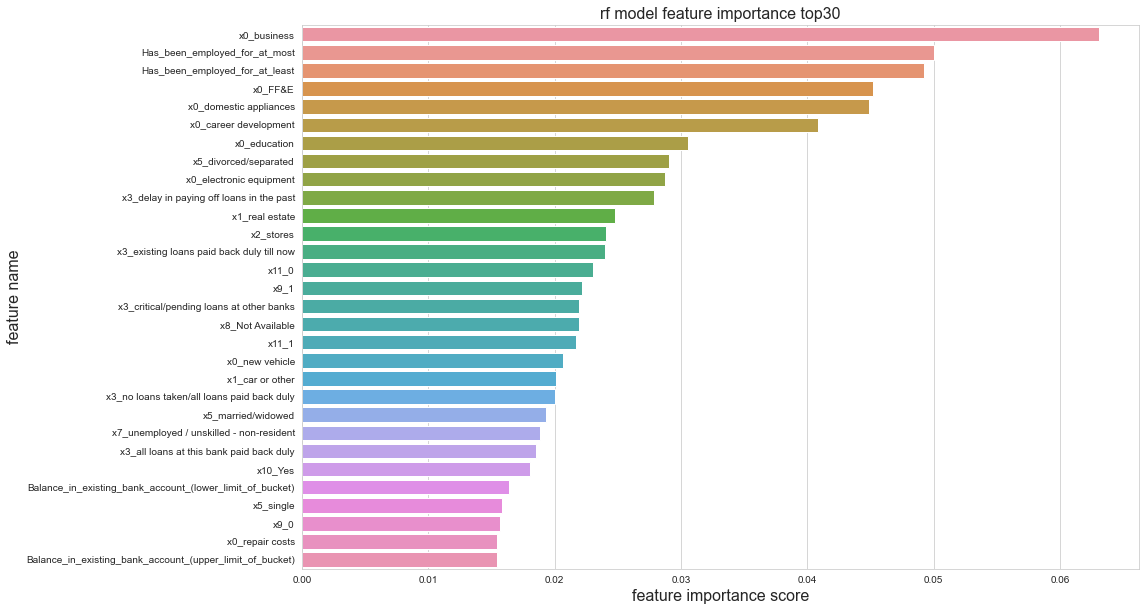

In [24]:
# random forest model feature contribution visualization
feature_importances = rf.feature_importances_
feature_names=np.array(feature_names)
indices = np.argsort(feature_importances)[::-1]
show_indices = indices[0:30]
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x=feature_importances[show_indices], y=feature_names[show_indices], ax=ax)
ax.set_title("rf model feature importance top30", fontsize=16)
ax.set_xlabel("feature importance score", fontsize=16)
ax.set_ylabel("feature name", fontsize=16)
plt.show()
plt.close()

In [25]:
top_feats=feature_names[feature_importances>0.02]
show_indices = indices[0:15]

In [583]:
list(top_feats)

['x0_FF&E',
 'x0_business',
 'x0_career development',
 'x0_domestic appliances',
 'x0_education',
 'x0_electronic equipment',
 'x0_new vehicle',
 'x1_car or other',
 'x1_real estate',
 'x2_stores',
 'x3_critical/pending loans at other banks',
 'x3_delay in paying off loans in the past',
 'x3_existing loans paid back duly till now',
 'x5_divorced/separated',
 'x5_married/widowed',
 'x8_Not Available',
 'x9_1',
 'x11_0',
 'x11_1',
 'Has_been_employed_for_at_least',
 'Has_been_employed_for_at_most']

In [26]:
lr = LogisticRegression(solver="sag", class_weight="balanced")
lr.fit(x_train_en[:,show_indices], y_train_en)
lr_y_pred = lr.predict(x_test_en[:,show_indices])
get_model_metrics(y_test, lr_y_pred)


Confusion Matrix:
[[130  85]
 [ 21  61]]
Precision score: 0.4178082191780822
Recall score: 0.7439024390243902
Accuracy Score with Cost: 0.5305555555555556


C:\Users\rajanp\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


##### 2. Running K fold CV to check average model metrics

we can check if the model is performing good even in held out sets. Therefore a k fold model was run which gave us a recal of 0.70 which is not too low than the recall we had got.

In [27]:
cv = RepeatedStratifiedKFold(n_splits=12, n_repeats=5, random_state=1)
n_scores = cross_val_score(lr, x_train_en[:,show_indices], y_train_en, scoring='recall', cv=cv, n_jobs=-1, error_score='raise')

print('Recall: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Recall: 0.726 (0.113)


##### 3. Parameter Tuning using Grid Search CV

The model can still be improved if we tune some of the parameters.
The parameters that were tried out were 
1. penalty - regularization type,
2. c- regularization strength,
3. Solver - Optimization algorithm


As expected the final model gave good results of 0.87 of recall.


In [646]:
param_grid = {'C': [0.05, 0.04, 0.03, 0.02, 0.01, 0.10],
             'penalty' : ['l1', 'l2'],
            'solver' : ['liblinear','sag','sagd','lbfgs','newton-cg']}
clf = GridSearchCV(estimator=lr, param_grid=param_grid,scoring='recall',cv=cv, n_jobs=-1 )
clf.fit(x_train_en[:,show_indices], y_train_en)    
best_parameters = clf.best_params_
print(best_parameters)

{'C': 0.04, 'penalty': 'l1', 'solver': 'liblinear'}


In [649]:
lr = LogisticRegression(C=0.04,penalty='l1',solver='liblinear', class_weight="balanced")
lr.fit(x_train_en[:,show_indices], y_train_en)
lr_y_pred = lr.predict(x_test_en[:,show_indices])
get_model_metrics(y_test, lr_y_pred)

Confusion Matrix:
[[ 95 120]
 [ 10  72]]
Precision score: 0.375
Recall score: 0.8780487804878049
Accuracy Score with Cost: 0.5107033639143731


### 4. Additional details

While solving this problem I felt the below Additional details would have helped to predict even better
1. Monthly surplus income of applicants
2. credit score or credit history from other loans/banks
3. Interest rate. This would help estimate the potential gain or loss by optimizing the threshold parameter on this metric to get maximise profit(interest) wile minimizing loss